# PART 2 - Evaluation of COMPAS dataset

#### Group Members : 
                Marck-Edward KEMEH - marck-edward.kemeh@grenoble-inp.org
                Irman FAQRIZAL - irman.faqrizal@univ-grenoble-alpes.fr

In [1]:
# Increase my page width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
# Ignore annoying warnings
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
import urllib
import os,sys
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import tensorflow as tf
import scikitplot as skplt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from pylab import rcParams
from torch import nn, optim
from sklearn.model_selection import train_test_split
from sklearn import feature_extraction, preprocessing
from random import seed, shuffle
import math
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 10, 6
RANDOM_SEED = 42
df = pd.read_csv('compas-scores-two-years.csv')

<h2>2.1 Preprocessing </h2>
Before going further to building the classifiers, we will preprocess our data. First we select the needed colums and removing empty values.

In [2]:
df = df[df.columns[~df.isnull().any()]]
df = df[['sex','age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 
         'is_violent_recid', 'v_decile_score', 'event', 'two_year_recid']]
df.head()

,sex,age_cat,race,juv_fel_count,juv_misd_count,priors_count,c_charge_degree,is_violent_recid,v_decile_score,event,two_year_recid
0,Male,Greater than 45,Other,0,0,0,F,0,1,0,0
1,Male,25 - 45,African-American,0,0,0,F,1,1,1,1
2,Male,Less than 25,African-American,0,0,4,F,0,3,0,1
3,Male,Less than 25,African-American,0,1,1,F,0,6,0,0
4,Male,25 - 45,Other,0,0,2,F,0,1,0,0


Next we need to convert string data into values/ numbers to be able to use it to train, test and predict

In [3]:
df['sex'].replace({'Male': 1, 'Female': 2}, inplace = True)
df['age_cat'].replace({'Greater than 45': 1, '25 - 45': 2, 'Less than 25': 3}, inplace = True)
df['race'].replace({'Other': 1, 'African-American': 2, 'Caucasian': 3, 'Hispanic': 4, 'Native American': 5, 'Asian': 6}, inplace = True)
df['c_charge_degree'].replace({'F': 1, 'M': 2}, inplace = True)
df.head()

,sex,age_cat,race,juv_fel_count,juv_misd_count,priors_count,c_charge_degree,is_violent_recid,v_decile_score,event,two_year_recid
0,1,1,1,0,0,0,1,0,1,0,0
1,1,2,2,0,0,0,1,1,1,1,1
2,1,3,2,0,0,4,1,0,3,0,1
3,1,3,2,0,1,1,1,0,6,0,0
4,1,2,1,0,0,2,1,0,1,0,0


Next step is to divide our dataset. we divide the data into train and test set. we will use 0.2 percent of the training dataset as the test set. We also separate the features (X) and the ground truth (y).

In [4]:
X = df[['sex','age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 
         'is_violent_recid', 'v_decile_score', 'event']]
y = df[['two_year_recid']] #ground truth
classes = ['No Recid', 'Recid']

# Arrange the data : Training, Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

<h2>2.2 Classifiers</h2>
In this part we will present different type of classifiers. The first goal is to compare them with the compas classifier in terms of overall performance, in this case we will the basic metrics such as accuracy, precision, and recall. Then we will observe and compare the fairness to the existing COMPAS classifier.

<h4>1. Logistic Regresssion</h4>

In [5]:
# Logistic Regression 
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train.values.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

              precision    recall  f1-score   support

    No Recid       0.89      0.97      0.93       823
       Recid       0.95      0.84      0.89       620

    accuracy                           0.91      1443
   macro avg       0.92      0.90      0.91      1443
weighted avg       0.91      0.91      0.91      1443

Overall Accuracy :  0.9112959112959113


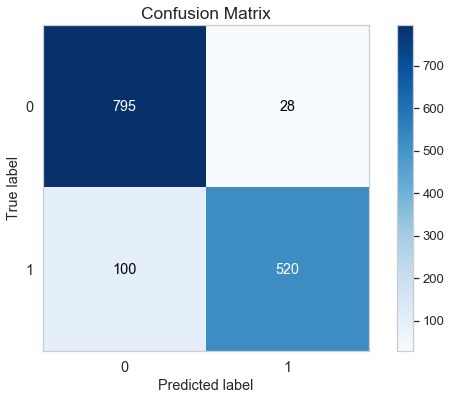

In [6]:
y_pred = log_reg.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_test, y_pred)))

<h4>2. Support Vector Machine</h4>

In [7]:
clfsvm = svm.SVC()
clfsvm.fit(X_train, y_train.values.ravel())

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

              precision    recall  f1-score   support

    No Recid       0.89      0.96      0.92       823
       Recid       0.94      0.84      0.89       620

    accuracy                           0.91      1443
   macro avg       0.92      0.90      0.91      1443
weighted avg       0.91      0.91      0.91      1443

Overall Accuracy :  0.9106029106029107


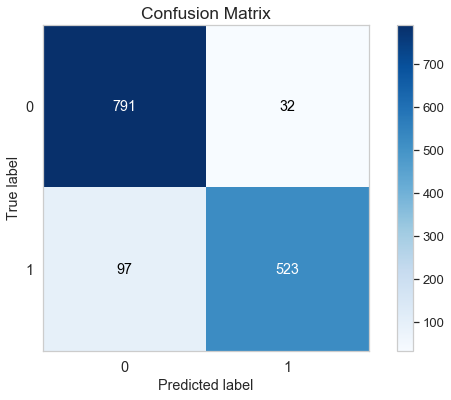

In [8]:
y_pred = clfsvm.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_test, y_pred)))

<h4>3. Decision Tree Classifier </h4>

In [9]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

              precision    recall  f1-score   support

    No Recid       0.87      0.93      0.90       823
       Recid       0.90      0.81      0.85       620

    accuracy                           0.88      1443
   macro avg       0.88      0.87      0.88      1443
weighted avg       0.88      0.88      0.88      1443

Overall Accuracy :  0.8794178794178794


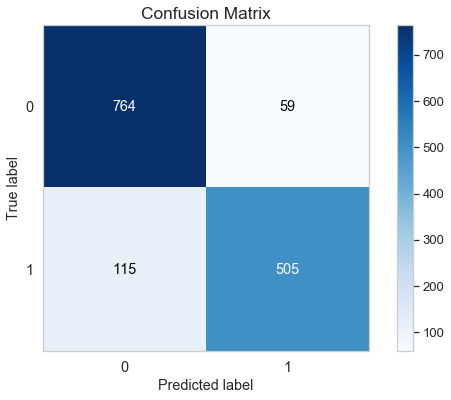

In [10]:
y_pred = clf.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_test, y_pred)))

<h4>4. K Nearest Neighbors </h4>

In [11]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train.values.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

              precision    recall  f1-score   support

    No Recid       0.86      0.92      0.89       823
       Recid       0.88      0.80      0.84       620

    accuracy                           0.87      1443
   macro avg       0.87      0.86      0.86      1443
weighted avg       0.87      0.87      0.87      1443

Overall Accuracy :  0.8669438669438669


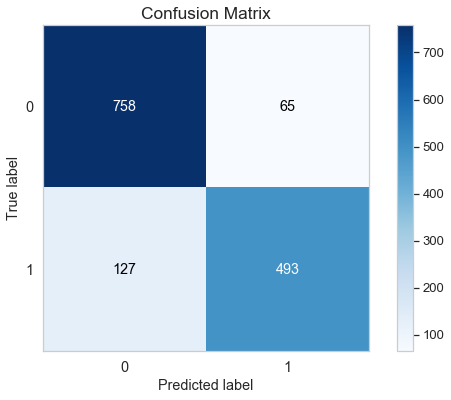

In [12]:
y_pred = neigh.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_test, y_pred)))

<h4>5. Neural Network </h4>
In order to train the neural network we will have to split the data training again to get validation set. We then need to convert them into a tensor to be able to train and test with Pytorch.

In [13]:
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.1, random_state=RANDOM_SEED)

# conversion to tensor
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())
X_validate = torch.from_numpy(X_validate.to_numpy()).float()
y_validate = torch.squeeze(torch.from_numpy(y_validate.to_numpy()).float())

print("Training\t :"+ str(X_train.shape) +", "+ str(y_train.shape))
print("Testing\t\t :"+ str(X_test.shape) +", "+ str(y_test.shape))
print("Validation\t :"+ str(X_validate.shape) +", "+ str(y_validate.shape))

Training	 :torch.Size([5193, 10]), torch.Size([5193])
Testing		 :torch.Size([1443, 10]), torch.Size([1443])
Validation	 :torch.Size([578, 10]), torch.Size([578])


#### First Model
Our first model will use simple architecture of neural network which has 2 hidden layers, both have 5 neurons and relu activation functions.

In [ ]:
# Defining the model #1
class fifthmodel(nn.Module):
  def __init__(self, n_features):
    super(fifthmodel, self).__init__()
    self.fc1 = nn.Linear(n_features, 5)
    self.fc2 = nn.Linear(5, 3)
    self.fc3 = nn.Linear(3, 1)
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

net = fifthmodel(X_train.shape[1])
print(net)

def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)
def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)

criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
print("\n")
max_epochs = 400
batch_size = 100
batch_number = math.ceil(len(X_train)/batch_size)
for epoch in range (max_epochs):
    for batch_idx in range (batch_number):
        # Set up batch
        batch_end = ((batch_idx+1) * batch_size -1)
        batch_start = batch_idx * batch_size
        if (batch_idx == (batch_number-1)):
            batch_end = (len(X_train) -1)
        batch_x = X_train[batch_start : batch_end]
        batch_y = y_train[batch_start : batch_end]
        
        # Fit the training data and validate
        train_pred = net(batch_x)
        train_pred = torch.squeeze(train_pred)
        train_loss = criterion(train_pred, batch_y)
        train_acc = calculate_accuracy(batch_y, train_pred)
        y_validate_pred = net(X_validate)
        y_validate_pred = torch.squeeze(y_validate_pred)
        validate_loss = criterion(y_validate_pred, y_validate)
        validation_acc = calculate_accuracy(y_validate, y_validate_pred)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    if epoch % 50 == 0:
        print( f'''epoch { {epoch} } \t==> Train : - Loss: {round_tensor(train_loss)}, Acc: {round_tensor(train_acc)} \t|| Validation : - Loss: {round_tensor(validate_loss)}, Acc: {round_tensor(validation_acc)}''')


# Test the model using test set
y_pred = net(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_test, y_pred)))
skplt.metrics.plot_confusion_matrix(y_test, y_pred)

fifthmodel(
  (fc1): Linear(in_features=10, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=1, bias=True)
)


epoch {0} 	==> Train : - Loss: 0.704, Acc: 0.457 	|| Validation : - Loss: 0.702, Acc: 0.452
epoch {50} 	==> Train : - Loss: 0.346, Acc: 0.891 	|| Validation : - Loss: 0.311, Acc: 0.901
epoch {100} 	==> Train : - Loss: 0.325, Acc: 0.891 	|| Validation : - Loss: 0.299, Acc: 0.901


We observed that the accuracy reduced a little by 0.012 as compared to the original third model. We can say that trying to increase the accuracy of the classifier does not have to do with only adding more layers and neurons to the network. We can also observe overfitting starting at epoch 2400.
### Second model
In this model we added more layers and neurons. We also try to use different activation function.

In [ ]:
# Defining the model  #2
# Adding layers and neurons
class fourthmodel(nn.Module):

  def __init__(self, n_features):
    super(fourthmodel, self).__init__()
    self.fc1 = nn.Linear(n_features, 20)
    self.fc2 = nn.Linear(20, 20)
    self.fc3 = nn.Linear(20, 10)
    self.fc4 = nn.Linear(10, 1)

  def forward(self, x):
    x = torch.tanh(self.fc1(x))
    x = torch.tanh(self.fc2(x))
    x = torch.tanh(self.fc3(x))
    return torch.sigmoid(self.fc4(x))

net = fourthmodel(X_train.shape[1])
print(net)

def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)

criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
print("\n")
max_epochs = 400
batch_size = 100
batch_number = math.ceil(len(X_train)/batch_size)
for epoch in range (max_epochs):
    for batch_idx in range (batch_number):
        # Set up batch
        batch_end = ((batch_idx+1) * batch_size -1)
        batch_start = batch_idx * batch_size
        if (batch_idx == (batch_number-1)):
            batch_end = (len(X_train) -1)
        batch_x = X_train[batch_start : batch_end]
        batch_y = y_train[batch_start : batch_end]
        
        # Fit the training data and validate
        train_pred = net(batch_x)
        train_pred = torch.squeeze(train_pred)
        train_loss = criterion(train_pred, batch_y)
        train_acc = calculate_accuracy(batch_y, train_pred)
        y_validate_pred = net(X_validate)
        y_validate_pred = torch.squeeze(y_validate_pred)
        validate_loss = criterion(y_validate_pred, y_validate)
        validation_acc = calculate_accuracy(y_validate, y_validate_pred)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    if epoch % 50 == 0:
        print( f'''epoch { {epoch} } \t==> Train : - Loss: {round_tensor(train_loss)}, Acc: {round_tensor(train_acc)} \t|| Validation : - Loss: {round_tensor(validate_loss)}, Acc: {round_tensor(validation_acc)}''')


# Test the model using test set
y_pred = net(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_test, y_pred)))
skplt.metrics.plot_confusion_matrix(y_test, y_pred)

### Predictions based on best performing model

we want to define a new dataset to use for prediction and observe fairness. We will use criminals labelled with the various risk score/decile score but having a two_year_recid or for this analysis.


In [ ]:
df2 = pd.read_csv('compas-scores-two-years.csv')

df2['sex'].replace({'Male': 1, 'Female': 2}, inplace = True)
df2['age_cat'].replace({'Greater than 45': 1, '25 - 45': 2, 'Less than 25': 3}, inplace = True)
df2['race'].replace({'Other': 1, 'African-American': 2, 'Caucasian': 3, 'Hispanic': 4, 'Native American': 5, 'Asian': 6}, inplace = True)
df2['c_charge_degree'].replace({'F': 1, 'M': 2}, inplace = True)

#no two_year _recid with high label
df2 = df2.loc[(df2['two_year_recid']==0) & (df2['score_text']=='High') & (df2['race']==2)]
# print ('shape of filtered data is ', df2.shape)

df2 = df2[df.columns[~df.isnull().any()]]
dfY = df2[['two_year_recid', ]]
dfX = df2[['sex','age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 
         'is_violent_recid', 'v_decile_score', 'event', ]]

print ('shape of data is ', dfX.shape)

#prediction
y_test = torch.from_numpy(dfY.to_numpy()).float()
X_test = torch.from_numpy(dfX.to_numpy()).float()
y_pred = net(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
skplt.metrics.plot_confusion_matrix(y_test, y_pred)

## todo - define fairness
## explain output of predictions to explain